In [245]:
#importing data exploration libraries
import numpy as np
import pandas as pd
import missingno
from itertools import product

#importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#import machine learning related libraries
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_scorefrom sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

# Handling Warning
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [55]:
#reading the dataset
data = pd.read_csv('unscrambl_data.csv')

In [56]:
data.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [57]:
#dropping duplicate rows
data = data.drop_duplicates()
data.dtypes

Year-Month                        int64
Agency Number                     int64
Agency Name                      object
Cardholder Last Name             object
Cardholder First Initial         object
Description                      object
Amount                          float64
Vendor                           object
Transaction Date                 object
Posted Date                      object
Merchant Category Code (MCC)     object
dtype: object

In [58]:
data.shape

(427410, 11)

<Axes: >

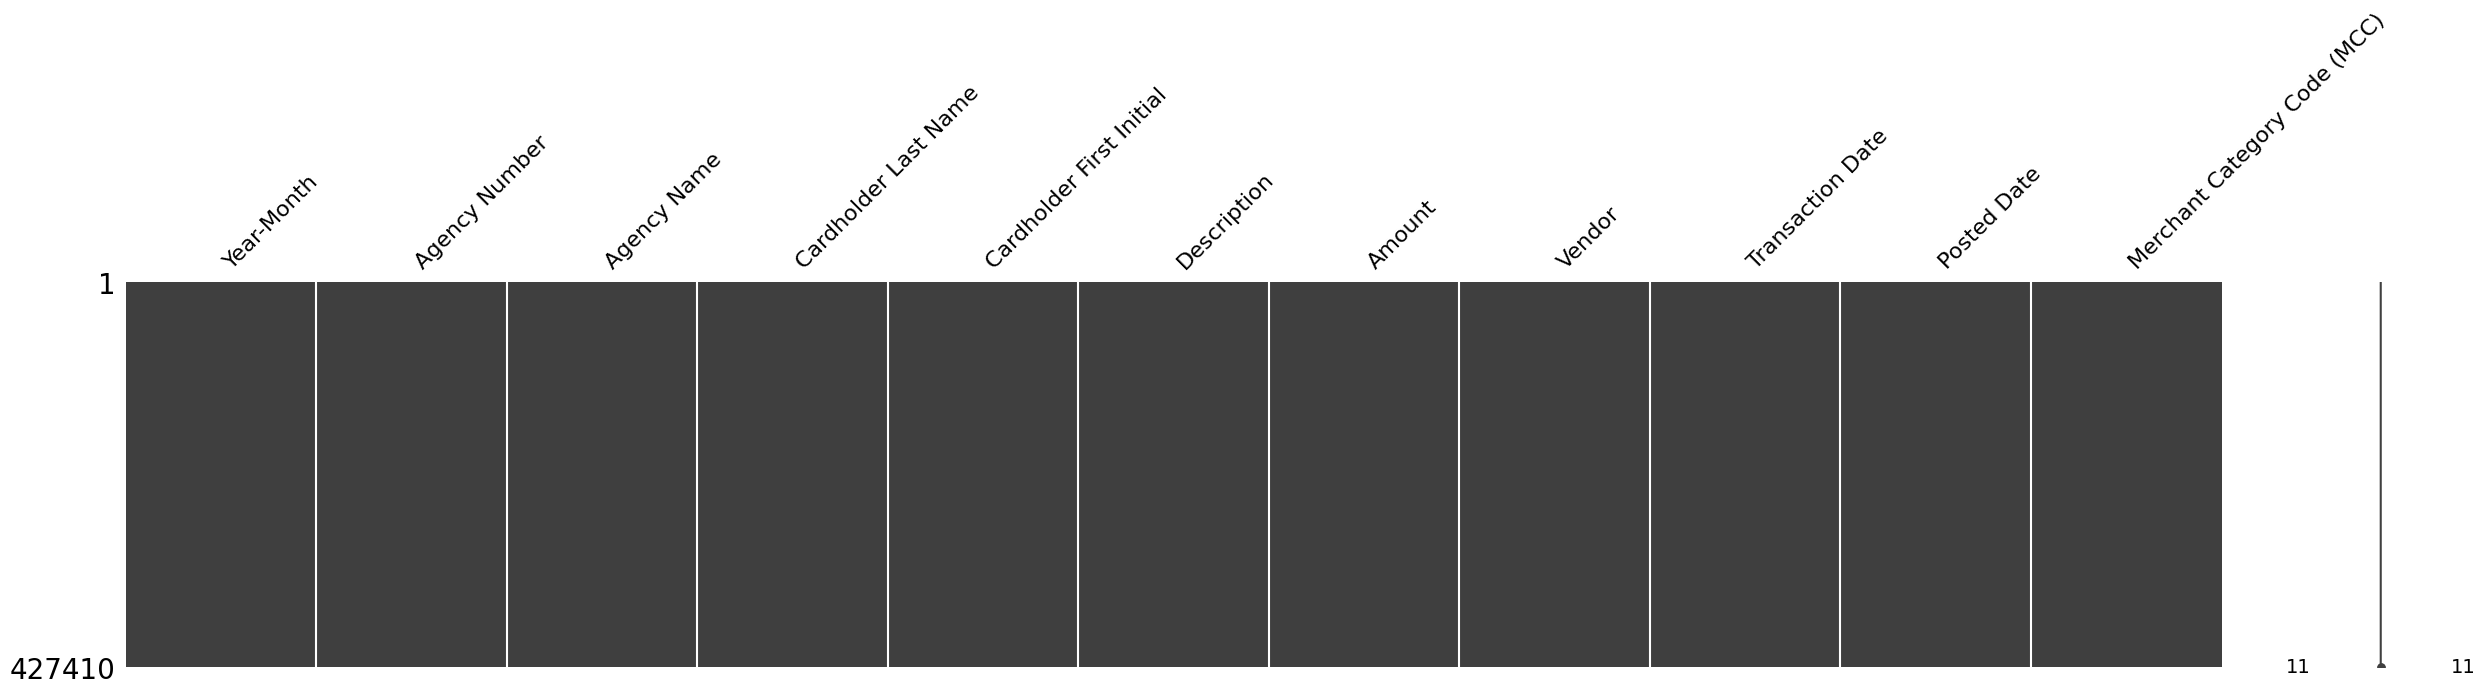

In [59]:
#checking if there are missing values
missingno.matrix(data, figsize = (30,5))

<Axes: >

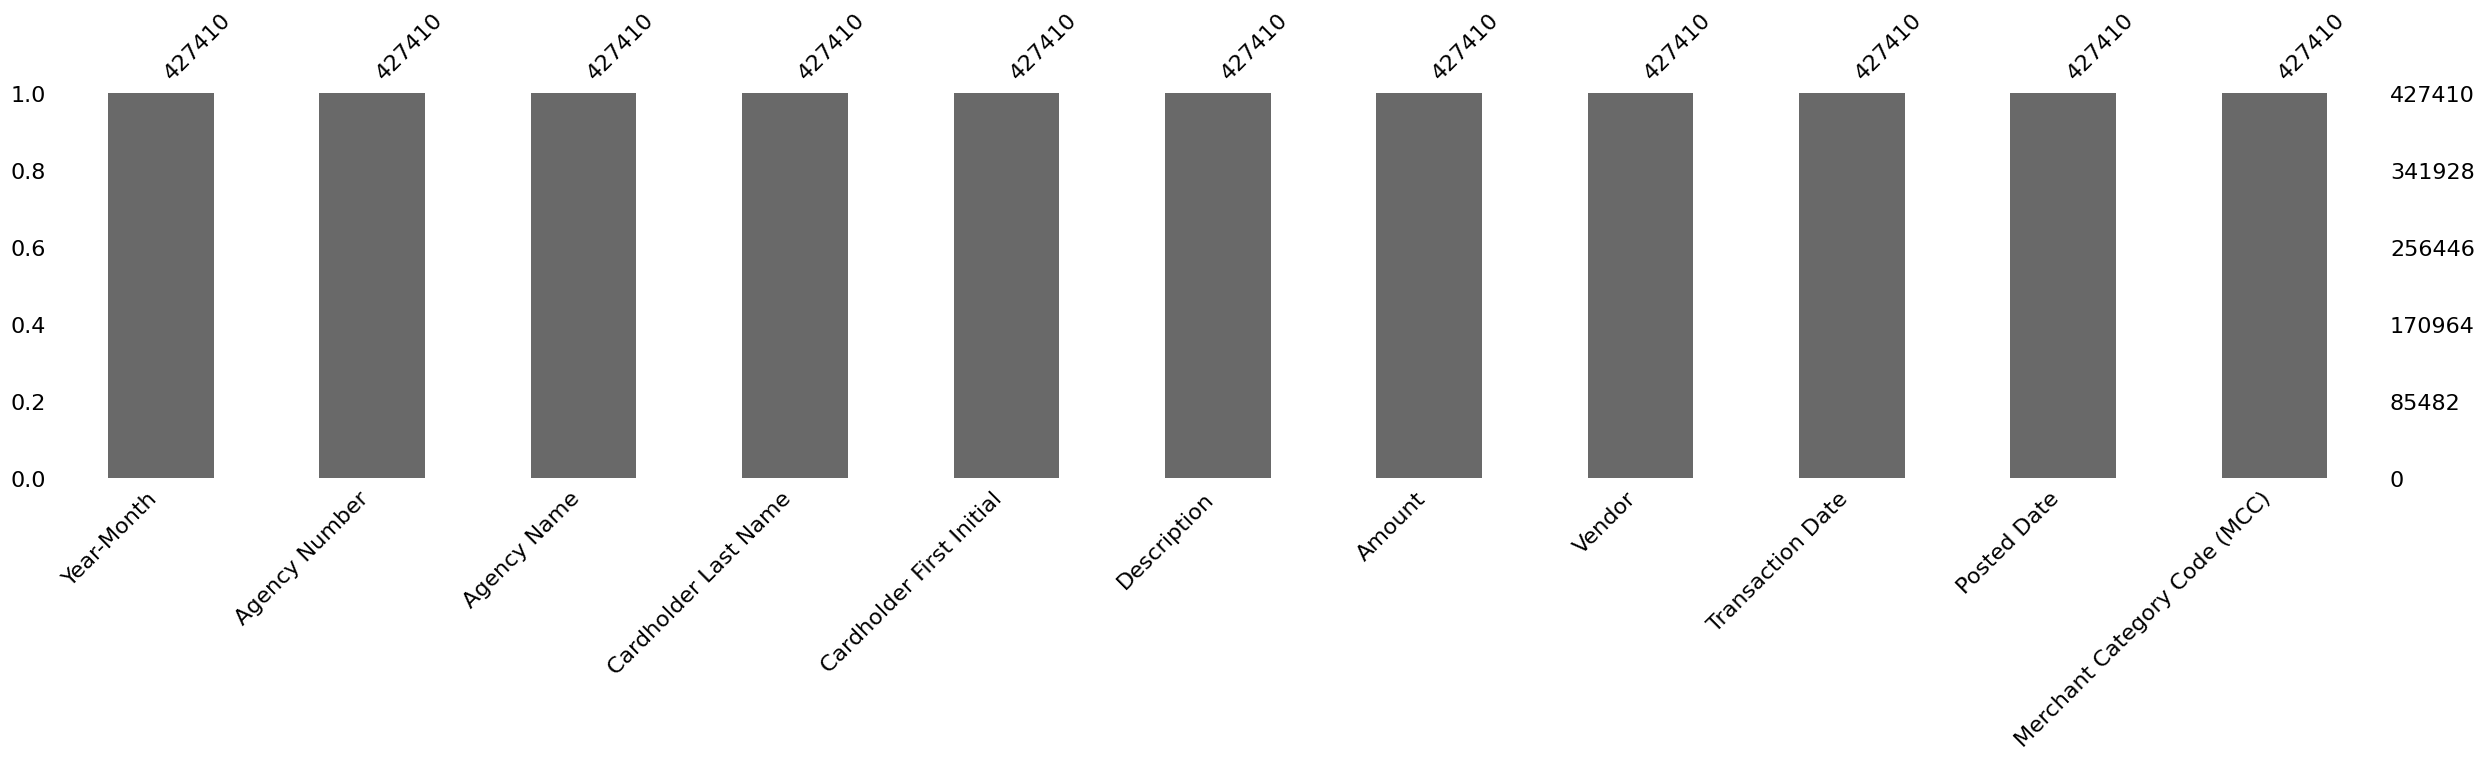

In [60]:
missingno.bar(data, sort='ascending', figsize = (30,5))

In [61]:
#renaming the columns
data.columns = map(str.lower, data.columns)
data.columns = data.columns.str.replace(' ', '_')

In [62]:
#creating a column for name as a unique identifier
data['name'] = data['cardholder_last_name'] + '.' + data['cardholder_first_initial']

In [63]:
#converting column name to string
data['name'] = data['name'].astype(str)

In [64]:
#creating a unique id per each name
data['id'] = data[['name']].sum(axis=1).map(hash)

### Overall Distribution of Amounts

(array([20795., 28566., 40274., 22322., 17175., 16047., 13120., 12572.,
        12902.,  9317.]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 99.]),
 <BarContainer object of 10 artists>)

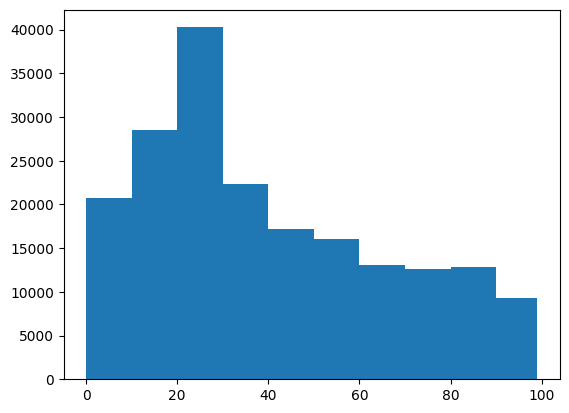

In [65]:
plt.hist(data['amount'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99])

### Top 5 Vendors

In [66]:
n = 5
data['vendor'].value_counts()[:n].index.tolist()

['STAPLES',
 'WW GRAINGER',
 'AMAZON MKTPLACE PMTS',
 'Amazon.com',
 'BILL WARREN OFFICE PRODUC']

### Top 5 Merchants

In [67]:
data.groupby('merchant_category_code_(mcc)')['amount'].sum().sort_values(ascending=False)

merchant_category_code_(mcc)
DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP AND SUP.    10915700.24
INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED               10739522.62
COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFTWARE          9736219.58
COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED              8130566.57
MISCELLANEOUS AND SPECIALTY RETAIL STORES                   5389961.86
                                                              ...     
SHOE REPR SHPS,SHOE SHINE PARLRS,AND HAT CLEANING SHPS           20.97
LA QUINTA RESORT                                                  0.00
EXTENDED STAY AMERICA                                             0.00
PRIMADONNA HOTEL AND CASINO                                     -55.37
USED MERCHANDISE AND SECONDHAND STORES                        -4678.28
Name: amount, Length: 435, dtype: float64

## Clustering 

In [68]:
# creating function for detailed descriptive analytic
def summary_stats(df_model, n=4):
    # central tendency: mean, median
    mean = pd.DataFrame(df_model.apply(np.mean)).T
    median = pd.DataFrame(df_model.apply(np.median)).T

    # distribution: ,std, min, max, range, skew, kurtosis
    std = pd.DataFrame(df_model.apply(np.std)).T
    min_value = pd.DataFrame(df_model.apply(min)).T
    max_value = pd.DataFrame(df_model.apply(max)).T
    range_value = pd.DataFrame(df_model.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(df_model.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(df_model.apply(lambda x: x.kurtosis())).T

    # concatenates
    summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
    summary_stats.columns = ['attributes','min','max', 'range','mean','median', 'std','skewness','kurtosis']
    
    return round(summary_stats, n)

In [69]:
# creating a new dataframe for clustering
cluster_data = data[['name', 'amount', 'merchant_category_code_(mcc)']].copy()

In [70]:
# counting the unique merchants per customer
cluster_data['unique_merchants'] = cluster_data.groupby('name')['merchant_category_code_(mcc)'].transform('nunique')

In [71]:
# getting the sum of transaction per customer
cluster_data['total_txn'] = cluster_data.groupby('name')['amount'].transform('sum')

In [72]:
# getting the total count of transactions per customer
cluster_data['frequency'] = cluster_data.groupby('name')['amount'].transform('count')

In [73]:
cluster_data.head()

,name,amount,merchant_category_code_(mcc),unique_merchants,total_txn,frequency
0,Mason.C,890.00,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,43,41323.86,155
1,Mason.C,368.96,SHERATON,43,41323.86,155
2,Massey.J,165.82,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,29,62012.92,142
3,Massey.T,96.39,"GROCERY STORES,AND SUPERMARKETS",33,43351.37,125
4,Mauro-Herrera.M,125.96,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",12,6661.08,71


In [74]:
cluster_data = cluster_data.drop(['name', 'amount', 'merchant_category_code_(mcc)'], axis=1)
cluster_data = cluster_data.drop_duplicates()


In [75]:
cluster_data.shape

(5194, 3)

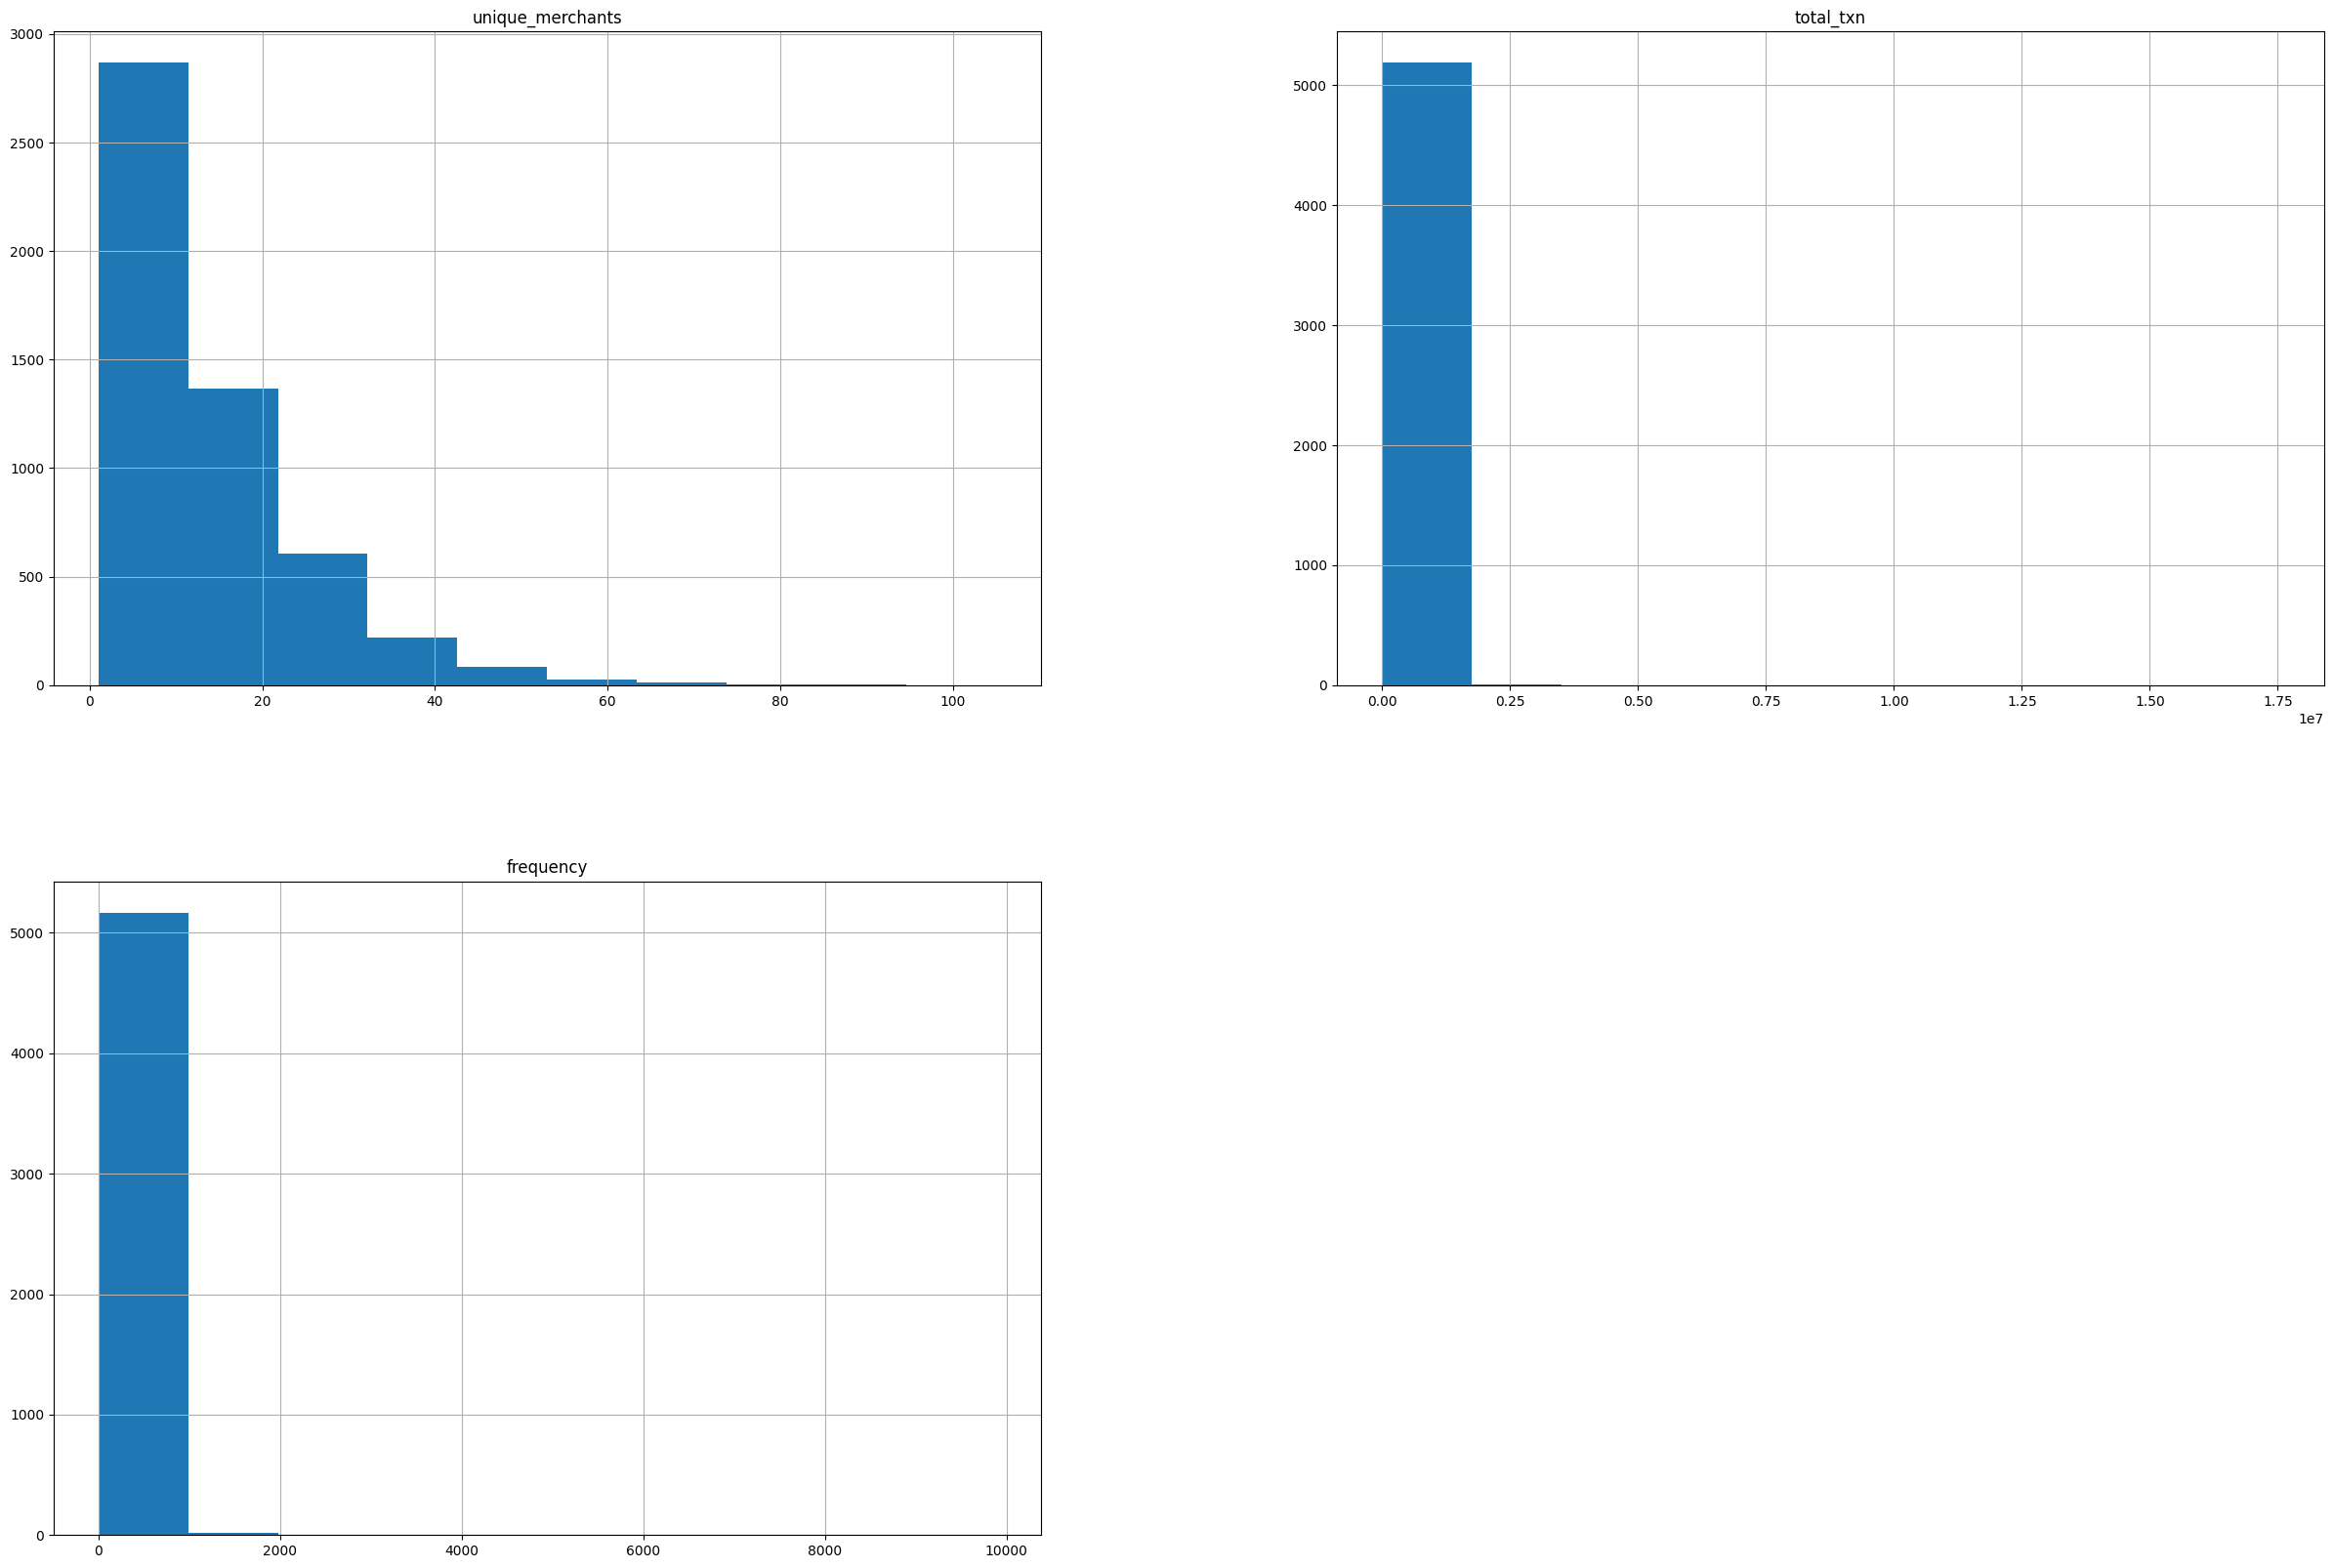

In [76]:
# Distribution plot to visualize data distribution

hist_b_ho = cluster_data.hist(bins=10,figsize=(30,20))
hist_b_ho
plt.show()

### Outlier Detection

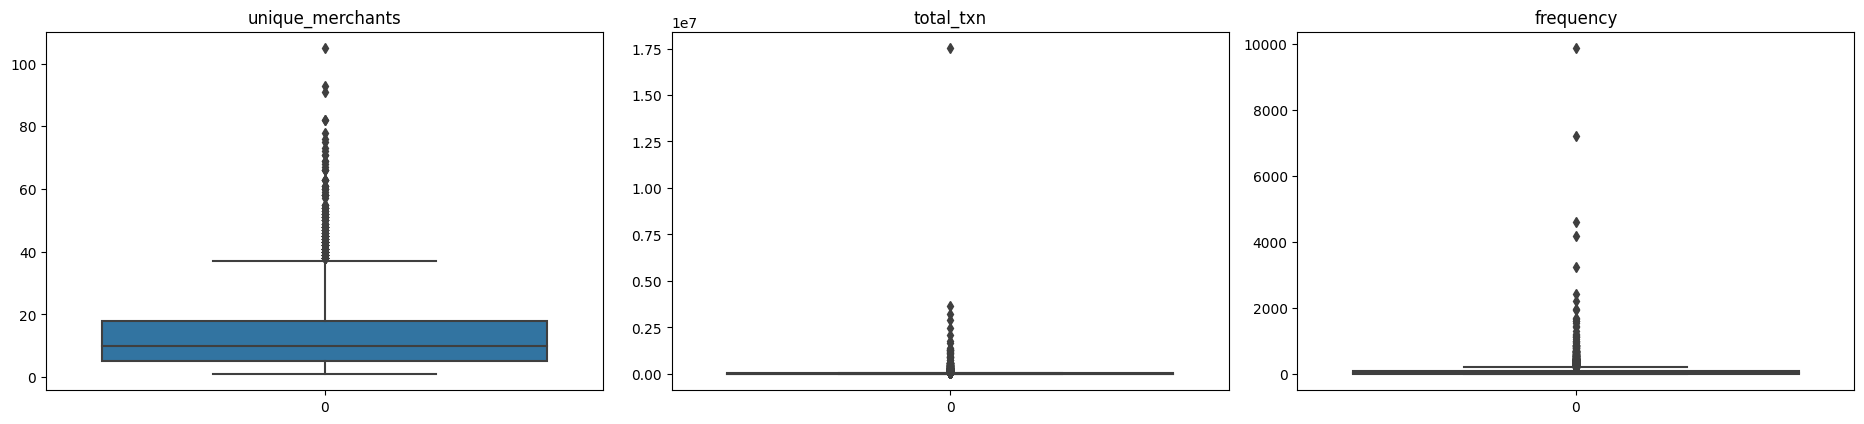

In [77]:
# plot for outliers detection

plt.figure(figsize=(25,20))
for i in range(len(cluster_data.columns)):
    plt.subplot(5,4,i+1)
    sns.boxplot(cluster_data[cluster_data.columns[i]])
    plt.title(cluster_data.columns[i])
    
plt.tight_layout()

In [78]:
# creating function to generate IQR, lower limit, and Upper limit

def find_outlier(df, feature):
    print('Outlier ' + feature)
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR: {iqr}')

    Lower_Limit = q1 - limit
    Upper_Limit = q3 + limit
    print(f'Lower_Limit: {Lower_Limit}')
    print(f'Upper_Limit: {Upper_Limit}')
    print('_________________________')

In [79]:
# check IQR, upper limit, and lower limit for each feature

for i in cluster_data :
    find_outlier(cluster_data, i)

Outlier unique_merchants
IQR: 13.0
Lower_Limit: -14.5
Upper_Limit: 37.5
_________________________
Outlier total_txn
IQR: 21367.5625
Lower_Limit: -29938.73625
Upper_Limit: 55531.51375
_________________________
Outlier frequency
IQR: 77.0
Lower_Limit: -103.5
Upper_Limit: 204.5
_________________________


As the outliers in the data are primarily a result of the dataset's characteristics, we have opted not to remove them. Instead, we will experiment with various models that are appropriate for this particular dataset.

### PCA

In [80]:
# Model Init
number_of_cluster = np.arange(2,11) # Number of Clusters
np.random.seed(2022) # Set global randomseed for sklearn models

In [81]:
#running PCA with full components
pca_all = PCA(n_components=len(cluster_data.columns), random_state = 2022)
pca_all.fit(cluster_data)
variance = pca_all.explained_variance_ratio_
var = np.cumsum(variance)*100

#plot for information extracted
fig = px.line(x=np.arange(len(cluster_data.columns))+1, y=var, markers=True)
fig.update_xaxes(title_text='# of Features')
fig.update_yaxes(title_text='% Variance Explained')
fig.update_layout(width=900)

In [82]:
# Reducing the dimensions of the data 
pca_n = PCA(n_components = 2, random_state = 2022) 
X_principal = pca_n.fit_transform(cluster_data)
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

summary_stats(X_principal)

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,P1,-39656.0469,1.749214e+07,1.753180e+07,0.0,-28007.8354,274044.372,51.6079,3210.9829
1,P2,-4265.8944,8.839747e+03,1.310564e+04,-0.0,-39.8160,220.294,19.1701,705.6103


### K-Medoids

The **K-Medoids clustering technique**, also referred to as Partitioning Around Medoids (PAM), is a modified version of the K-Means algorithm. Instead of using all observations within a cluster, K-Medoids employs a medoid to reduce sensitivity to extreme values in the dataset and create a more robust partition.

We use 3 distance metrics : 
1. **Cosine Similarity**: measure of similarity between two sequences of numbers.
1. **Euclidean Distance or Euclidean**: metric is the familiar and straightforward line between two elements or the minimum distance between two objects 
1. **Manhattan Distance**: the distance between two points is the sum of the absolute differences of their Cartesian coordinates. Simply it is the sum of the difference between the x-coordinates and y-coordinates. 

In [83]:
# Create Accumulator for matric
manhattan_s_scores = []
manhattan_db_scores = []
manhattan_calinski_scores = []
euclidean_s_scores = []
euclidean_db_scores = []
euclidean_calinski_scores = []
cosine_s_scores = []
cosine_db_scores = []
cosine_calinski_scores = []

kmedoids_metrics = {'manhattan': [manhattan_s_scores, manhattan_db_scores, manhattan_calinski_scores, 'rgb(128,177,211)'],
                    'euclidean': [euclidean_s_scores, euclidean_db_scores, euclidean_calinski_scores, 'rgb(141,211,199)'],
                    'cosine': [cosine_s_scores, cosine_db_scores, cosine_calinski_scores, 'rgb(251,128,114)']}

#looping to run k-medoids by each distance metrics
for i, j in product(kmedoids_metrics, number_of_cluster):
    kmedoids = KMedoids(metric=i, n_clusters=j, random_state = 2022)
    kmedoids.fit(X_principal)
    kmedoids_metrics[i][0].append(silhouette_score(
        X_principal, kmedoids.labels_, metric=i))
    kmedoids_metrics[i][1].append(davies_bouldin_score(
        X_principal, kmedoids.labels_))
    kmedoids_metrics[i][2].append(calinski_harabasz_score(
        X_principal, kmedoids.labels_))


In [84]:
#creating plot to compare the result
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=.01)

for i in kmedoids_metrics:
    for j, k in zip(range(1, 4), ['Silhouette', 'Davies Bouldin', 'Calinski-Harabasz']):
        fig.append_trace(go.Scatter(x=list(number_of_cluster), y=kmedoids_metrics[i][j-1], name=i.title(),
                                    legendgroup=i, line_color=kmedoids_metrics[i][-1],
                                    showlegend=False if j != 1 else True), row=j, col=1)
        fig.update_yaxes(title_text=k, row=j, col=1)

fig.update_xaxes(title_text='Number of Clusters', row=3)
fig.update_layout(height=800, width=900,
                  legend_title_text='Metrics',
                  title_text='Metric Scores',
                  legend_traceorder='reversed')

We decided that 2 are the best number of cluster for each distance parameter by it's score stability.

In [85]:
#using 2 as number of clusters
kmedoids_manhattan = KMedoids(metric="manhattan", n_clusters=2, random_state = 1234)
kmedoids_euclidean = KMedoids(metric="euclidean", n_clusters=2, random_state = 1234)
kmedoids_cosine = KMedoids(metric="cosine", n_clusters=2, random_state = 1234)

#running the algorithm
kmedoids_manhattan.fit(X_principal)
kmedoids_euclidean.fit(X_principal)
kmedoids_cosine.fit(X_principal)

KMedoids(metric='cosine', n_clusters=2, random_state=1234)

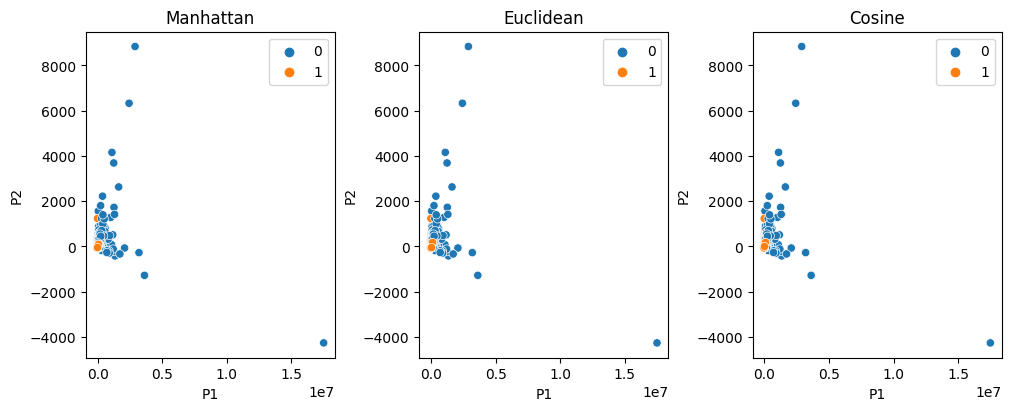

In [86]:
#creating plot to compare the result by each distance parameter
kmedoids_graph = {'Manhattan': kmedoids_manhattan,
                  'Euclidean': kmedoids_euclidean,
                  'Cosine': kmedoids_cosine}

plt.figure(figsize=(10, 4), constrained_layout=True)
for i, j in zip(kmedoids_graph, range(1,4)):
    plt.subplot(1,3,j)
    sns.scatterplot(x='P1', y='P2', data=X_principal,
                    hue= kmedoids_graph[i].labels_)
    sns.scatterplot(data = None,
                    x = kmedoids_graph[i].cluster_centers_[:,0], 
                    y = kmedoids_graph[i].cluster_centers_[:,1])
    plt.title(i)

In [87]:
#choosing best model for clustering
model_fix = KMedoids(metric="cosine", n_clusters=2, random_state = 1234)
model_fix.fit(X_principal)
model_fix_centers = model_fix.cluster_centers_
model_fix_labels = model_fix.predict(X_principal)
model_fix_centers

array([[ 3.05532119e+04,  1.89164391e+02],
       [-2.72141252e+04, -3.21756818e+00]])

In [88]:
#add the cluster to dataframe
df_cluster = pd.concat([cluster_data, pd.DataFrame({'cluster' :model_fix_labels})], axis = 1)
df_cluster.head()

,unique_merchants,total_txn,frequency,cluster
0,43.0,41323.86,155.0,0.0
2,29.0,62012.92,142.0,0.0
3,33.0,43351.37,125.0,1.0
4,12.0,6661.08,71.0,1.0
6,15.0,19692.56,85.0,1.0


In [89]:
df_cluster['cluster'].value_counts()

1.0    4285
0.0     909
Name: cluster, dtype: int64

### Cluster Analysis

In [90]:
#separating the dataframe by cluster
cluster_0 = df_cluster[df_cluster['cluster'] == 0]
cluster_1 = df_cluster[df_cluster['cluster'] == 1]

In [91]:
#summary for each cluster
need_columns = ['unique_merchants', 'total_txn', 'frequency']
d={}
for i in need_columns:  
    d[i] = pd.DataFrame(df_cluster.groupby('cluster', axis = 0)[i].describe()[['mean', '50%', 'min', 'max']])

pd.concat(d, axis =1)

unique_merchants                      total_txn                    \
                    mean   50%  min   max          mean        50%    min   
cluster                                                                     
0.0            16.524590  14.0  1.0  82.0  37373.909290   9892.440  87.47   
1.0            16.368009  14.0  1.0  93.0  28253.428926  12541.265 -38.90   

                      frequency                     
                max        mean   50%  min     max  
cluster                                             
0.0      1658126.21  117.147541  50.0  1.0  4183.0  
1.0      1374870.07   85.996644  52.0  1.0  2426.0

Text(0.5, 1.0, 'cluster 1')

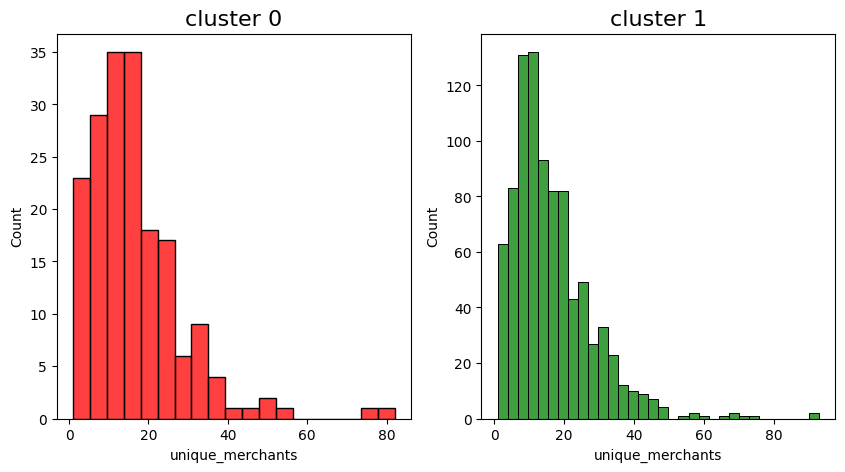

In [92]:
#plot comparison unique_merchants from each cluster
plt.figure(figsize=(21,5))
plt.subplot(1,4,1)
sns.histplot(cluster_0['unique_merchants'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,4,2)
sns.histplot(cluster_1['unique_merchants'], color='green' )
plt.title('cluster 1', size = 16)

Text(0.5, 1.0, 'cluster 1')

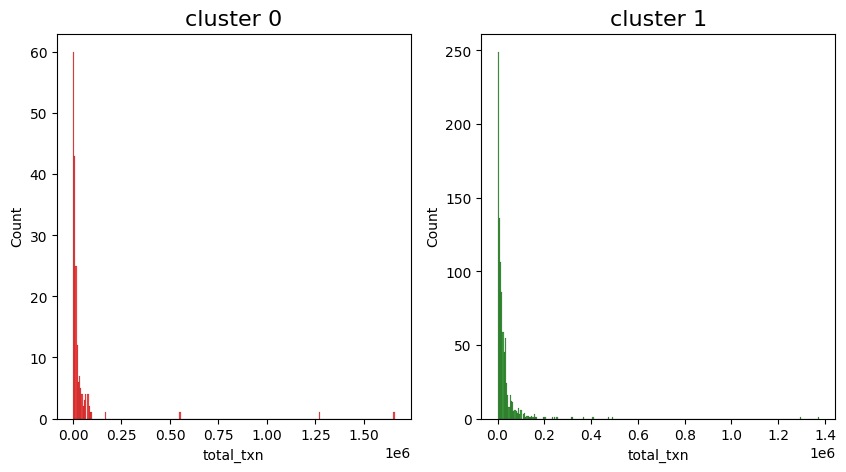

In [93]:
#plot comparison total transaction from each cluster
plt.figure(figsize=(21,5))
plt.subplot(1,4,1)
sns.histplot(cluster_0['total_txn'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,4,2)
sns.histplot(cluster_1['total_txn'], color='green')
plt.title('cluster 1', size = 16)

Text(0.5, 1.0, 'cluster 1')

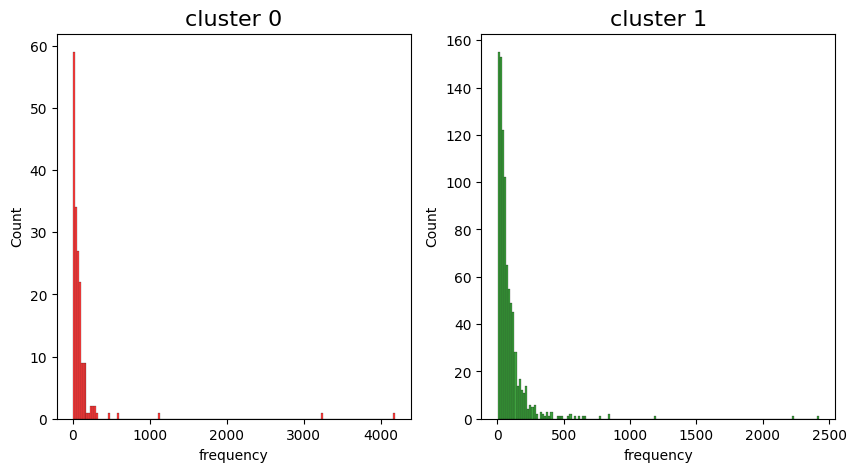

In [94]:
#plot comparison frequency from each cluster
plt.figure(figsize=(21,5))
plt.subplot(1,4,1)
sns.histplot(cluster_0['frequency'], color = 'red')
plt.title('cluster 0', size = 16)
plt.subplot(1,4,2)
sns.histplot(cluster_1['frequency'], color='green')
plt.title('cluster 1', size = 16)

### **Cluster 0**

### **Frequent Spender**

**Characteristic:**

- Love to spend
- Loyal to merchants

**Analysis :**
    
Users in this cluster are users who like to shop a lot in the same merchants that they already transacted with. They are frequent spenders that cause them to accumulate high total spent amount.

**Strategy :**
    
Since we have a list of the merchants that these users transact with, it's a good idea to partner with these merchants and have promotions to encourage the customers in this cluster to spend more.

### **Cluster 1**

### **Merchant Hoppers**

**Characteristic:**

- Average spenders
- Loves to change merchants
- Big spenders

**Analysis :**
    
Users in this cluster are users who like to shop a few items in each of the merchants that they already transacted with. They jump from merchant merchant but are willing to spend more in a single transaction

**Strategy :**
    
Having promotions/discounts specific to having to spend a certain amount of money on a single transaction can persuade the customers in this cluster to spend more

## Predict Customer Purchase

In [95]:
# converting column to datetime format
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data.head()

,year-month,agency_number,agency_name,cardholder_last_name,cardholder_first_initial,description,amount,vendor,transaction_date,posted_date,merchant_category_code_(mcc),name,id
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,Mason.C,-1416346172048272309
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,07/31/2013 12:00:00 AM,SHERATON,Mason.C,-1416346172048272309
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,Massey.J,-8459783059212433390
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS",Massey.T,-7041095971182196508
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",Mauro-Herrera.M,5851240607380667593


In [96]:
pd.DataFrame(data['transaction_date'].describe())

,transaction_date
count,427410
unique,392
top,2013-09-11 00:00:00
freq,2076
first,2013-04-17 00:00:00
last,2014-06-30 00:00:00


The dataframe is split into two.

- The first sub-dataframe assigned to the Python variable ctm_bhvr_dt contains purchases made by customers from 17-04-2013 to 30-03-2014. This dataframe will be used to study the behavioural purchases of the online customers.

- The second sub-dataframe assigned to the Python variable ctm_next_quarter will be used to study the behavioural purchases of the customers in the next quarter. That is, from 01-04-2014 to 30-06-2014.

In [339]:
ctm_bhvr_dt = data[(data['transaction_date'] < pd.Timestamp(2014,4,1)) & 
      (data['transaction_date'] >= pd.Timestamp(2013,4,17))].reset_index(drop=True)


ctm_next_quarter = data[(data['transaction_date'] < pd.Timestamp(2014,7,1)) & 
      (data['transaction_date'] >= pd.Timestamp(2014,4,1))].reset_index(drop=True)

In [340]:
# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['id'].unique())

# Rename the column to name.
ctm_dt.columns = ['CustomerID']

ctm_dt.head()

,CustomerID
0,-1416346172048272309
1,-8459783059212433390
2,-7041095971182196508
3,5851240607380667593
4,-7399177438948068119


Let's find the first purchase made by each customer in the next quarter.

In [341]:
# Create a dataframe with name and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('id')['transaction_date'].min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,-9220109800612881277,2014-04-18
1,-9216398372023571588,2014-04-04
2,-9215762619617199288,2014-04-11
3,-9213478118333759463,2014-04-12
4,-9212196898520664768,2014-04-01


Let's find the last purchase made by each customer in the dataframe ctm_bhvr_dt.

In [342]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('id')['transaction_date'].max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,CustomerID,MaxPurchaseDate
0,-9220109800612881277,2014-03-10
1,-9216398372023571588,2014-02-26
2,-9215762619617199288,2014-03-28
3,-9215087969393134483,2013-07-23
4,-9213478118333759463,2014-03-31


Let's merge the two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter.

In [343]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,-9220109800612881277,2014-03-10,2014-04-18
1,-9216398372023571588,2014-02-26,2014-04-04
2,-9215762619617199288,2014-03-28,2014-04-11
3,-9215087969393134483,2013-07-23,NaT
4,-9213478118333759463,2014-03-31,2014-04-12


Let's calculate the time difference in days between customer's last purchase in the dataframe ctm_last_purchase_bhvr_dt and the first purchase in the dataframe ctm_1st_purchase_in_next_quarter.

In [344]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,-9220109800612881277,2014-03-10,2014-04-18,39.0
1,-9216398372023571588,2014-02-26,2014-04-04,37.0
2,-9215762619617199288,2014-03-28,2014-04-11,14.0
3,-9215087969393134483,2013-07-23,NaT,NaN
4,-9213478118333759463,2014-03-31,2014-04-12,12.0


In [345]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,-1416346172048272309,NaN
1,-8459783059212433390,5.0
2,-7041095971182196508,5.0
3,5851240607380667593,10.0
4,-7399177438948068119,13.0


Update the dataframe ctm_dt by filling all missing values with 9999.

In [346]:
ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,-1416346172048272309,9999.0
1,-8459783059212433390,5.0
2,-7041095971182196508,5.0
3,5851240607380667593,10.0
4,-7399177438948068119,13.0


In [347]:
ctm_max_purchase = ctm_bhvr_dt.groupby('id')['transaction_date'].max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
ctm_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,-9220109800612881277,2014-03-10
1,-9216398372023571588,2014-02-26
2,-9215762619617199288,2014-03-28
3,-9215087969393134483,2013-07-23
4,-9213478118333759463,2014-03-31


Following that, we will establish certain attributes and append them to the ctm_dt dataframe in order to construct our machine learning model. The segmentation approach we will utilize is Recency - Frequency - Monetary Value.

### Recency

We should identify the most recent purchase date for each customer and calculate the number of days they have been inactive. Then, we can utilize K-means clustering to allocate customers a recency score.

In [348]:
# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency
0,-1416346172048272309,9999.0,68
1,-8459783059212433390,5.0,4
2,-7041095971182196508,5.0,2
3,5851240607380667593,10.0,9
4,-7399177438948068119,13.0,0


In [349]:
pd.DataFrame(ctm_dt.Recency.describe())

,Recency
count,4935.000000
mean,38.254103
std,63.227527
min,0.000000
25%,3.000000
50%,9.000000
75%,35.000000
max,277.000000


In [350]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

In [351]:
number_of_clusters = 2

In [352]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,-1416346172048272309,9999.0,68,0
1,-8459783059212433390,5.0,4,0
2,-7041095971182196508,5.0,2,0
3,5851240607380667593,10.0,9,0
4,-7399177438948068119,13.0,0,0


In [353]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [354]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,-1416346172048272309,9999.0,68,1
1,-8459783059212433390,5.0,4,1
2,-7041095971182196508,5.0,2,1
3,5851240607380667593,10.0,9,1
4,-7399177438948068119,13.0,0,1


In [355]:
#print cluster characteristics
ctm_dt.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,742.0,174.801887,51.976584,95.0,130.0,167.0,217.0,277.0
1,4193.0,14.090389,18.533101,0.0,3.0,6.0,18.0,94.0


### Frequency

In [356]:
#get order counts for each user and create a dataframe with it
ctm_frequency = data.groupby('id')['transaction_date'].count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

In [357]:
#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,-1416346172048272309,9999.0,68,1,155
1,-8459783059212433390,5.0,4,1,142
2,-7041095971182196508,5.0,2,1,125
3,5851240607380667593,10.0,9,1,71
4,-7399177438948068119,13.0,0,1,85


In [358]:
pd.DataFrame(ctm_dt.Frequency.describe())

,Frequency
count,4935.000000
mean,86.130294
std,243.837791
min,1.000000
25%,14.000000
50%,38.000000
75%,93.000000
max,9882.000000


In [359]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [360]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,-1416346172048272309,9999.0,68,1,155,1
1,-8459783059212433390,5.0,4,1,142,1
2,-7041095971182196508,5.0,2,1,125,1
3,5851240607380667593,10.0,9,1,71,1
4,-7399177438948068119,13.0,0,1,85,1


In [361]:
#see details of each cluster
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,5.0,5827.800000,2702.425244,3250.0,4183.0,4606.0,7218.0,9882.0
1,4930.0,80.307099,141.827298,1.0,14.0,38.0,92.0,2426.0


### Revenue

In [362]:
ctm_revenue = data.groupby('id')['amount'].sum().reset_index()
ctm_revenue.columns = ['CustomerID','Revenue']

In [363]:
#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,-1416346172048272309,9999.0,68,1,155,1,41323.86
1,-8459783059212433390,5.0,4,1,142,1,62012.92
2,-7041095971182196508,5.0,2,1,125,1,43351.37
3,5851240607380667593,10.0,9,1,71,1,6661.08
4,-7399177438948068119,13.0,0,1,85,1,19692.56


In [364]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

In [365]:
#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,-1416346172048272309,9999.0,68,1,155,1,41323.86,0
1,-8459783059212433390,5.0,4,1,142,1,62012.92,0
2,-7041095971182196508,5.0,2,1,125,1,43351.37,0
3,5851240607380667593,10.0,9,1,71,1,6661.08,0
4,-7399177438948068119,13.0,0,1,85,1,19692.56,0


In [366]:
#show details of the dataframe
ctm_dt.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4934.0,3.363817e+04,130333.277098,-4184.64,2.447543e+03,8.290195e+03,2.470446e+04,3654238.35
1,1.0,1.752761e+07,NaN,17527610.79,1.752761e+07,1.752761e+07,1.752761e+07,17527610.79


In [367]:
#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
1,173.631861,52.684070,2.178023e+04
2,14.110580,91.731311,3.575374e+04
3,0.000000,1619.000000,1.752761e+07


In [368]:
#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,-1416346172048272309,9999.0,68,1,155,1,41323.86,0,2
1,-8459783059212433390,5.0,4,1,142,1,62012.92,0,2
2,-7041095971182196508,5.0,2,1,125,1,43351.37,0,2
3,5851240607380667593,10.0,9,1,71,1,6661.08,0,2
4,-7399177438948068119,13.0,0,1,85,1,19692.56,0,2


In [369]:
ctm_class_10 = ctm_class.copy()

In [370]:
ctm_class_10['NextPurchaseDayRange'] = 1  ## less than 10 days
ctm_class_10.loc[ctm_class.NextPurchaseDay>10,'NextPurchaseDayRange'] = 0 # more than 10 days
ctm_class_10.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,NextPurchaseDayRange
0,-1416346172048272309,9999.0,68,1,155,1,41323.86,0,2,0
1,-8459783059212433390,5.0,4,1,142,1,62012.92,0,2,1
2,-7041095971182196508,5.0,2,1,125,1,43351.37,0,2,1
3,5851240607380667593,10.0,9,1,71,1,6661.08,0,2,1
4,-7399177438948068119,13.0,0,1,85,1,19692.56,0,2,0


In [371]:
ctm_class_10['NextPurchaseDayRange'].value_counts()

0    3219
1    1716
Name: NextPurchaseDayRange, dtype: int64

In [372]:
ctm_class_10 = ctm_class_10.drop('NextPurchaseDay', axis=1)

In [373]:
X, y = ctm_class_10.drop('NextPurchaseDayRange', axis=1), ctm_class_10.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [374]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [375]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
xgb.XGBClassifier,0.735647,0.641513,0.680278,0.619217,0.833503
KNeighborsClassifier,0.711319,0.617383,0.652120,0.599191,0.229512
DecisionTreeClassifier,0.708055,0.597271,0.642634,0.571412,0.039270
RandomForestClassifier,0.679331,0.585879,0.626811,0.565147,0.791481
SVC,0.672556,0.538092,0.595109,0.505389,1.120260
GaussianNB,0.578521,0.443451,0.501824,0.414695,0.043381
LogisticRegression,0.504813,0.492173,0.503649,0.503276,0.060690


In [376]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

In [377]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.8817122593718338)

In [378]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.87


In [379]:
ctm_class_5 = ctm_class.copy()

In [380]:
ctm_class_5['NextPurchaseDayRange'] = 1
ctm_class_5.loc[ctm_class.NextPurchaseDay>5,'NextPurchaseDayRange'] = 0
ctm_class_5.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,NextPurchaseDayRange
0,-1416346172048272309,9999.0,68,1,155,1,41323.86,0,2,0
1,-8459783059212433390,5.0,4,1,142,1,62012.92,0,2,1
2,-7041095971182196508,5.0,2,1,125,1,43351.37,0,2,1
3,5851240607380667593,10.0,9,1,71,1,6661.08,0,2,0
4,-7399177438948068119,13.0,0,1,85,1,19692.56,0,2,0


In [381]:
ctm_class_5['NextPurchaseDayRange'].value_counts()

0    3930
1    1005
Name: NextPurchaseDayRange, dtype: int64

In [382]:
ctm_class_5 = ctm_class_5.drop('NextPurchaseDay', axis=1)

In [383]:
X, y = ctm_class_5.drop('NextPurchaseDayRange', axis=1), ctm_class_5.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [384]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [385]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
xgb.XGBClassifier,0.797281,0.641965,0.670628,0.633193,0.863729
KNeighborsClassifier,0.791178,0.616653,0.644900,0.610461,0.231646
DecisionTreeClassifier,0.777710,0.602290,0.635625,0.592693,0.035946
SVC,0.752596,0.549923,0.591499,0.537884,0.682346
RandomForestClassifier,0.737758,0.585381,0.621998,0.584327,0.801738
GaussianNB,0.656535,0.454524,0.507710,0.454242,0.042788
LogisticRegression,0.515957,0.465499,0.515419,0.509928,0.065058


In [386]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

In [387]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.9019756838905775)

In [388]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.89


In [389]:
ctm_class_1 = ctm_class.copy()

In [390]:
ctm_class_1['NextPurchaseDayRange'] = 1
ctm_class_1.loc[ctm_class.NextPurchaseDay>1,'NextPurchaseDayRange'] = 0
ctm_class_1.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,NextPurchaseDayRange
0,-1416346172048272309,9999.0,68,1,155,1,41323.86,0,2,0
1,-8459783059212433390,5.0,4,1,142,1,62012.92,0,2,0
2,-7041095971182196508,5.0,2,1,125,1,43351.37,0,2,0
3,5851240607380667593,10.0,9,1,71,1,6661.08,0,2,0
4,-7399177438948068119,13.0,0,1,85,1,19692.56,0,2,0


In [391]:
ctm_class_1['NextPurchaseDayRange'].value_counts()

0    4662
1     273
Name: NextPurchaseDayRange, dtype: int64

In [392]:
ctm_class_1 = ctm_class_1.drop('NextPurchaseDay', axis=1)

In [393]:
X, y = ctm_class_1.drop('NextPurchaseDayRange', axis=1), ctm_class_1.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [394]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [395]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
KNeighborsClassifier,0.884318,0.589059,0.607934,0.606861,0.280712
xgb.XGBClassifier,0.874451,0.606325,0.625923,0.629378,0.820468
DecisionTreeClassifier,0.859017,0.575900,0.602204,0.599879,0.031378
SVC,0.836879,0.530732,0.562540,0.561322,0.268256
RandomForestClassifier,0.801334,0.545822,0.583387,0.591177,0.710151
GaussianNB,0.724164,0.432631,0.500082,0.485967,0.041263
LogisticRegression,0.504813,0.379799,0.500164,0.500177,0.063669


In [396]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

In [397]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.9582066869300911)

In [398]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.98
Accuracy of XGB classifier on test set: 0.96
